In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '', addFileNameCol = True)
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 328
The number of rows (Samples): 1845647, The number of columns: 20, number of unique sender id's: (328,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [10]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 163887


In [11]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [12]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [13]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [14]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1681760, The number of columns: 20


In [15]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [16]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [17]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [18]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [19]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [20]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [21]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [22]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [23]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [24]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [25]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [26]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Pre Processing (For Training Phase)

In [27]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [51]:
tps = pd.read_csv('types.csv')
tps['File Name'] = tps['File Name'].astype(str) + '.csv'


,File Name,Exploit Type
0,0xhabitat001.csv,Phishing
1,AnibusDAO001.csv,Phishing
2,AnySwap001.csv,Access control
3,BadgerDAO001.csv,Exploit
4,BadgerDAO002.csv,Exploit
...,...,...
345,Vadia Finance001.csv,Exit Scam
346,Vadia Finance002.csv,Exit Scam
347,VoltageFinance001.csv,Exploit
348,Wintermute001.csv,Access control


In [30]:
expd = dict(zip(tps['File Name'], tps['Exploit Type']))
expd

{'0xhabitat001.csv': 'Phishing',
 'AnibusDAO001.csv': 'Phishing',
 'AnySwap001.csv': 'Access control',
 'BadgerDAO001.csv': 'Exploit',
 'BadgerDAO002.csv': 'Exploit',
 'Bitmart001.csv': 'Exploit',
 'Bitpoint001.csv': 'Access control',
 'Bitpoint002.csv': 'Access control',
 'Bitpoint003.csv': 'Access control',
 'Bitpoint004.csv': 'Access control',
 'Bitpoint005.csv': 'Access control',
 'Bitpoint006.csv': 'Access control',
 'Bitpoint007.csv': 'Access control',
 'Bitpoint008.csv': 'Access control',
 'Bitpoint009.csv': 'Access control',
 'Bitpoint010.csv': 'Access control',
 'Bitpoint011.csv': 'Access control',
 'Bitpoint013.csv': 'Access control',
 'Bitpoint014.csv': 'Access control',
 'Bitpoint015.csv': 'Access control',
 'BoredApe001.csv': 'Exploit',
 'BrincFinance001.csv': 'Exploit',
 'BrincFinance002.csv': 'Exploit',
 'BuildFinance001.csv': 'Governance attack',
 'BuildFinance002.csv': 'Governance attack',
 'bZx001.csv': 'Access control',
 'ChainSwap001.csv': 'Exploit',
 'ChainSwap002.

In [32]:
dfData_['Exploit Type']  = dfData_.apply(lambda x: expd[x['File Name']] if x['File Name'] in expd else 'unknown', axis=1)


In [54]:
dsAttackType, dfAttackType = CalcAttackType(dfData)

In [57]:
sasa_ids = dfAttackType[dfAttackType['Attack Type'] == 'SASASW']['Asset ID'].to_list()
sama_ids = dfAttackType[dfAttackType['Attack Type'] == 'SAMASW']['Asset ID'].to_list()

In [58]:
dfData_sasa = dfData_[dfData_['Sender ID'].isin(sasa_ids)]
dfData_sama = dfData_[dfData_['Sender ID'].isin(sama_ids)]

In [34]:
#dfData_[ dfData_['Exploit Type'] == 'Abandoned'].shape

(2519, 99)

### K-fold training, using categorical variables (EXPERIMENT)

In [59]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [60]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_sasa.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_sasa[lSlctdFeatures].fillna(0, inplace = True)
dfX_ = dfData_sasa[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [61]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_sasa['Label']


In [64]:
l_sfs = ['Amount',
 'Gas Price',
 'Gas Used',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']


In [65]:
mX = mX[l_sfs]

exp type:  Access control


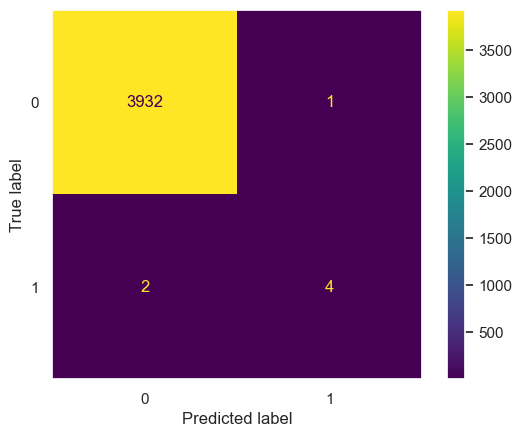

Accuracy         0.999238
F1               0.727273
Precision        0.800000
Recall           0.666667
ROC AUC Score    0.833206
dtype: float64


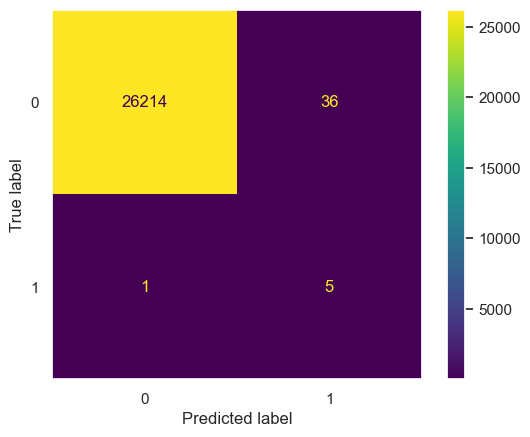

Accuracy         0.998591
F1               0.212766
Precision        0.121951
Recall           0.833333
ROC AUC Score    0.915981
dtype: float64


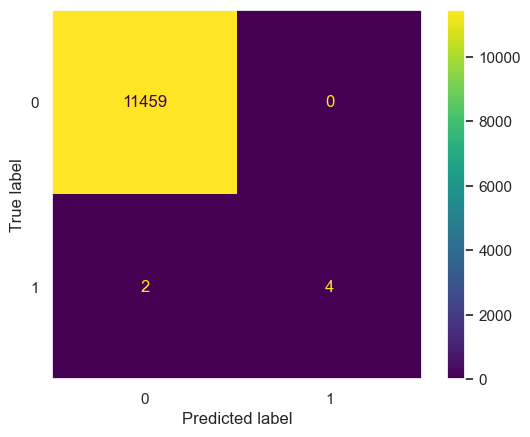

Accuracy         0.999826
F1               0.800000
Precision        1.000000
Recall           0.666667
ROC AUC Score    0.833333
dtype: float64
exp type recall :  Access control 0.7222222222222222
exp type:  Bank Run
exp type:  Exit Scam


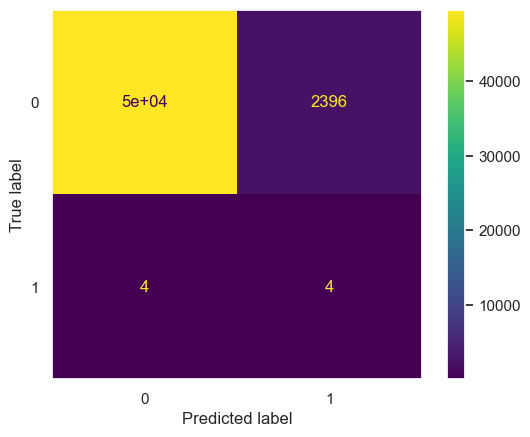

Accuracy         0.953884
F1               0.003322
Precision        0.001667
Recall           0.500000
ROC AUC Score    0.726977
dtype: float64


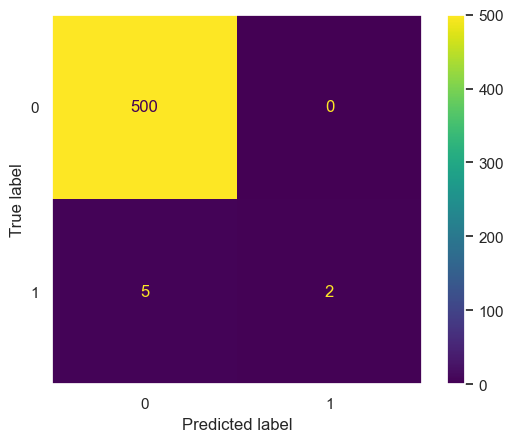

Accuracy         0.990138
F1               0.444444
Precision        1.000000
Recall           0.285714
ROC AUC Score    0.642857
dtype: float64


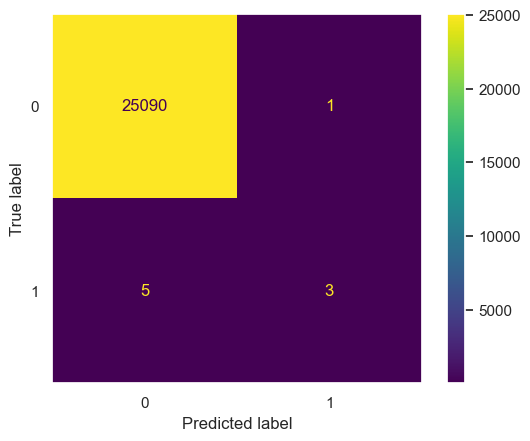

Accuracy         0.999761
F1               0.500000
Precision        0.750000
Recall           0.375000
ROC AUC Score    0.687480
dtype: float64
exp type recall :  Exit Scam 0.38690476190476186
exp type:  Exploit


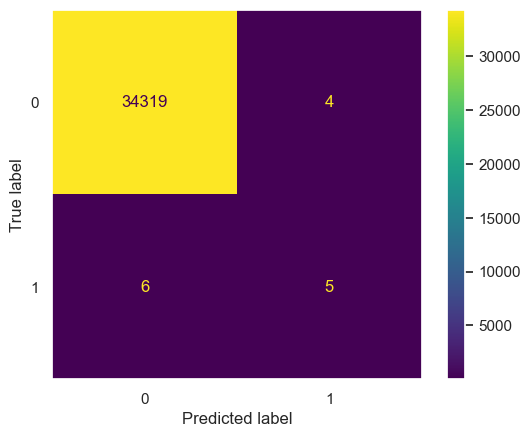

Accuracy         0.999709
F1               0.500000
Precision        0.555556
Recall           0.454545
ROC AUC Score    0.727214
dtype: float64


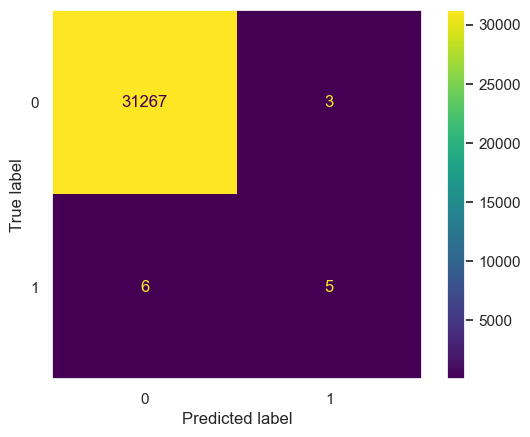

Accuracy         0.999712
F1               0.526316
Precision        0.625000
Recall           0.454545
ROC AUC Score    0.727225
dtype: float64


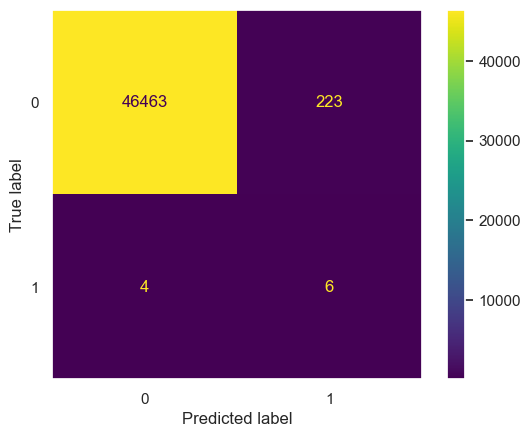

Accuracy         0.995139
F1               0.050209
Precision        0.026201
Recall           0.600000
ROC AUC Score    0.797612
dtype: float64
exp type recall :  Exploit 0.503030303030303
exp type:  Flash Loan Attack


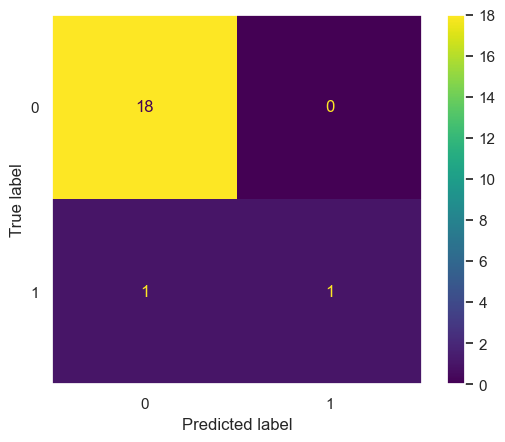

Accuracy         0.950000
F1               0.666667
Precision        1.000000
Recall           0.500000
ROC AUC Score    0.750000
dtype: float64


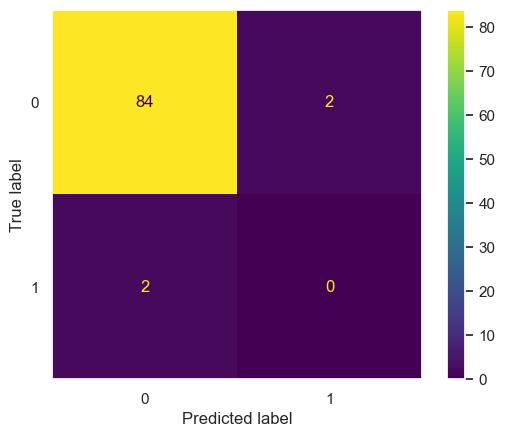

Accuracy         0.954545
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.488372
dtype: float64


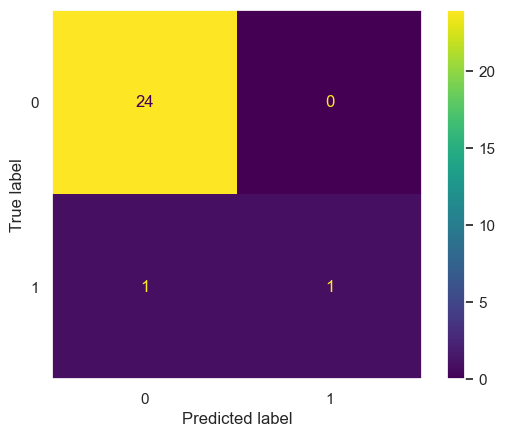

Accuracy         0.961538
F1               0.666667
Precision        1.000000
Recall           0.500000
ROC AUC Score    0.750000
dtype: float64
exp type recall :  Flash Loan Attack 0.3333333333333333
exp type:  Multisig


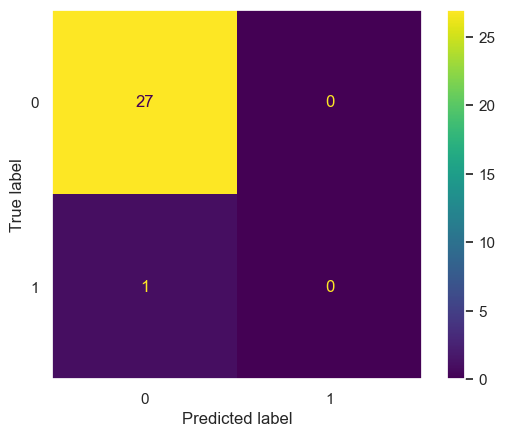

Accuracy         0.964286
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


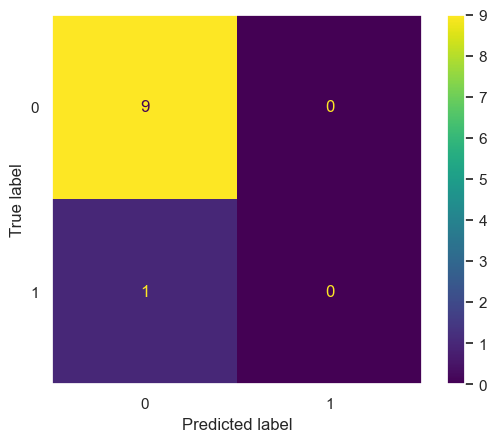

Accuracy         0.9
F1               0.0
Precision        0.0
Recall           0.0
ROC AUC Score    0.5
dtype: float64


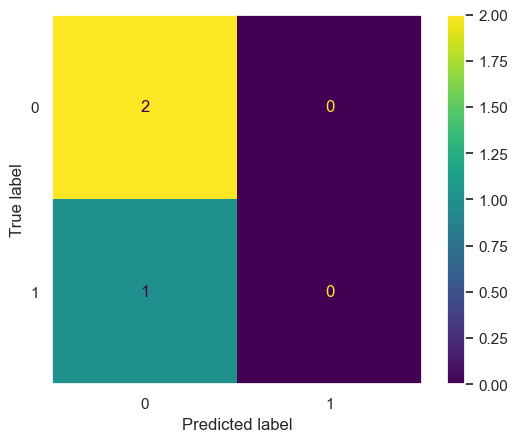

Accuracy         0.666667
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64
exp type recall :  Multisig 0.0
exp type:  Phishing


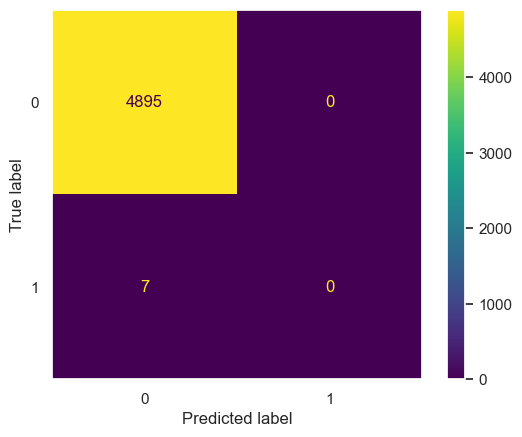

Accuracy         0.998572
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


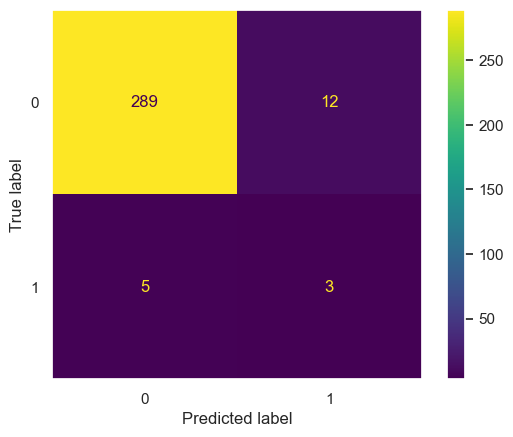

Accuracy         0.944984
F1               0.260870
Precision        0.200000
Recall           0.375000
ROC AUC Score    0.667566
dtype: float64


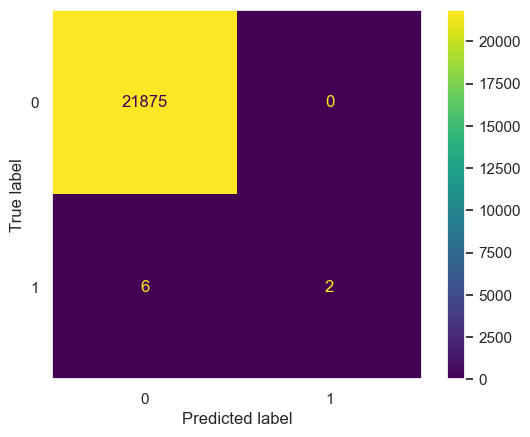

Accuracy         0.999726
F1               0.400000
Precision        1.000000
Recall           0.250000
ROC AUC Score    0.625000
dtype: float64
exp type recall :  Phishing 0.20833333333333334
exp type:  Private Key


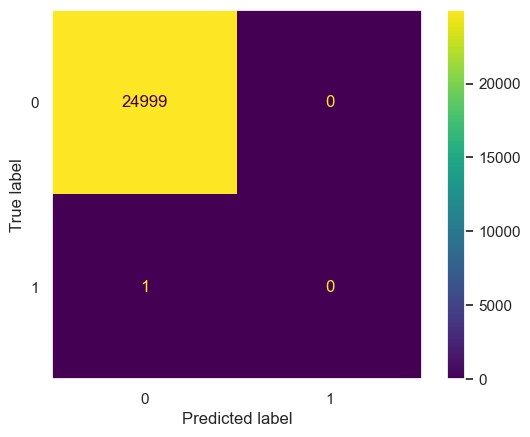

Accuracy         0.99996
F1               0.00000
Precision        0.00000
Recall           0.00000
ROC AUC Score    0.50000
dtype: float64


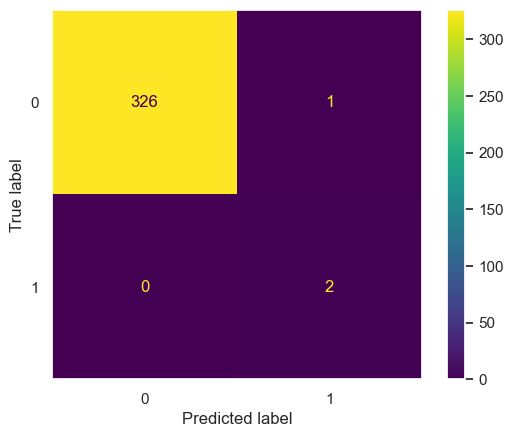

Accuracy         0.996960
F1               0.800000
Precision        0.666667
Recall           1.000000
ROC AUC Score    0.998471
dtype: float64


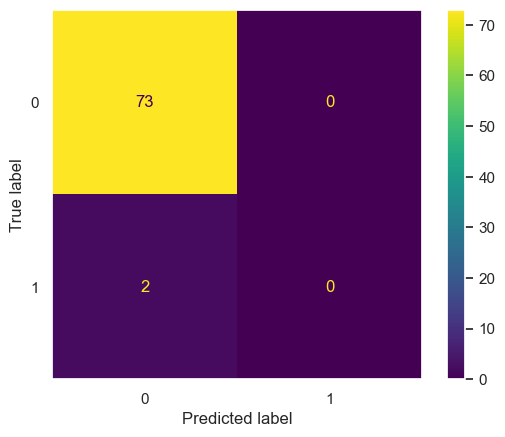

Accuracy         0.973333
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64
exp type recall :  Private Key 0.3333333333333333
exp type:  Reentrancy


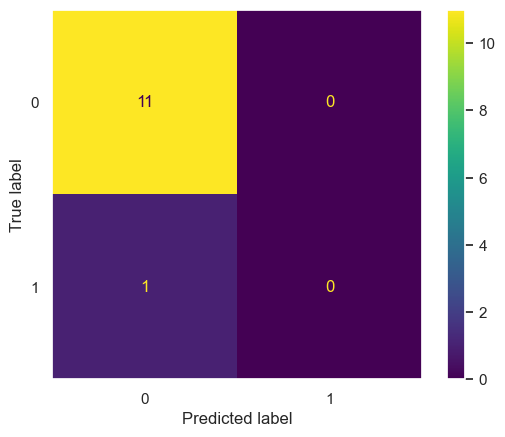

Accuracy         0.916667
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


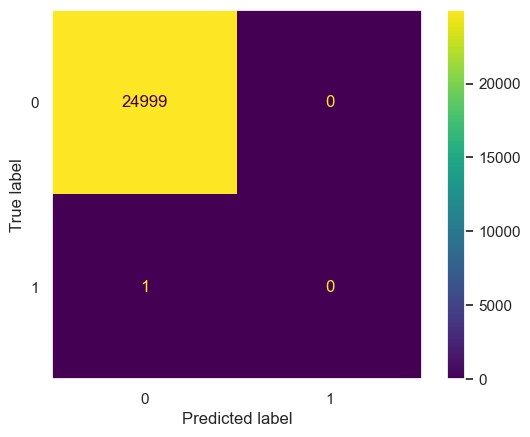

Accuracy         0.99996
F1               0.00000
Precision        0.00000
Recall           0.00000
ROC AUC Score    0.50000
dtype: float64
exp type recall :  Reentrancy 0.0
exp type:  Rugpull
exp type:  unknown


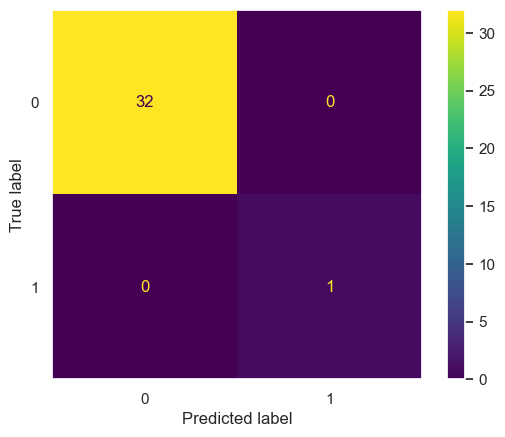

Accuracy         1.0
F1               1.0
Precision        1.0
Recall           1.0
ROC AUC Score    1.0
dtype: float64


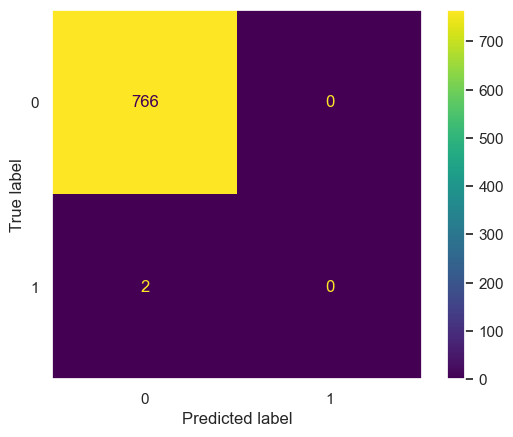

Accuracy         0.997396
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


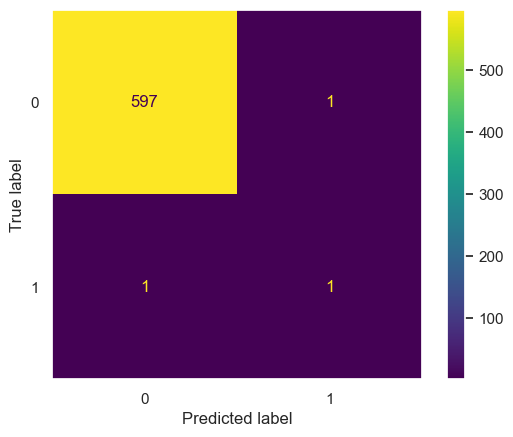

Accuracy         0.996667
F1               0.500000
Precision        0.500000
Recall           0.500000
ROC AUC Score    0.749164
dtype: float64
exp type recall :  unknown 0.5


In [67]:


from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
results = {}
for all_grp, one_grp in logo.split(mX, vY, groups = dfData_sasa['Exploit Type'].to_list()):#for all_grp, one_grp in logo.split(dfData_, dfData_['Label'], groups = dfData_['Exploit Type'].to_list()):#split(X):
    print('exp type: ' , dfData_sasa.iloc[one_grp]['Exploit Type'].to_list()[0])
    
    if dfData_sasa.iloc[one_grp]['Exploit Type'].to_list()[0] not in ['Bank Run' , 'Rugpull']:
        _, mX_, _, vY_ = mX.iloc[all_grp], mX.iloc[one_grp], vY.iloc[all_grp], vY.iloc[one_grp]
        _dfData = dfData_sasa.iloc[one_grp]
        hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
        
        recalls = []
        for vTrainIdx, vTestIdx in hKFoldSplt.split(mX_, vY_, groups = _dfData['Sender ID']):

            mXTrain, mXTest, vYTrain, vYTest = mX_.iloc[vTrainIdx], mX_.iloc[vTestIdx], vY_.iloc[vTrainIdx], vY_.iloc[vTestIdx]
            xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
            xgbModel.fit(mXTrain, vYTrain)
            vYPred = xgbModel.predict(mXTest)
            if vYPred.size != 0:
                DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
                print(GenClassifierSummaryResults(vYTest, vYPred))
                recalls.append(recall_score(vYTest, vYPred))
        print('exp type recall : ' , dfData_sasa.iloc[one_grp]['Exploit Type'].to_list()[0] , sum(recalls)/len(recalls))
        results[dfData_sasa.iloc[one_grp]['Exploit Type'].to_list()[0]] = sum(recalls)/len(recalls)
    #print('file exp: ' , dfData_.iloc[one_grp]['Exploit Type'].to_list()[0] , mX_.shape[0])  
    #dft = dfData.iloc[vTestIdx]
    #DisplayConfusionMatrix(dft['Label'], vYPred['Alert Rule'], lClasses = [0,1])
    #print('recall : ' , recall_score(dft['Label'], vYPred['Alert Rule']), '   precision: ' , precision_score(dft['Label'], vYPred['Alert Rule']))
    #results.append({dfData_.iloc[vTestIdx]['File Name'].to_list()[0] : [vYPred,recall_score(dft['Label'], vYPred['Alert Rule'])]})
    #if recall_score(vYTest, vYPred) != 1:
    #    prob_files.append(dfData_.iloc[vTestIdx]['File Name'].to_list()[0])    

In [68]:
#SASA
results

{'Access control': 0.7222222222222222,
 'Exit Scam': 0.38690476190476186,
 'Exploit': 0.503030303030303,
 'Flash Loan Attack': 0.3333333333333333,
 'Multisig': 0.0,
 'Phishing': 0.20833333333333334,
 'Private Key': 0.3333333333333333,
 'Reentrancy': 0.0,
 'unknown': 0.5}

In [69]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_sama.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_sama[lSlctdFeatures].fillna(0, inplace = True)
dfX_ = dfData_sama[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [70]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_sama['Label']


mX = mX[l_sfs]


exp type:  Abandoned


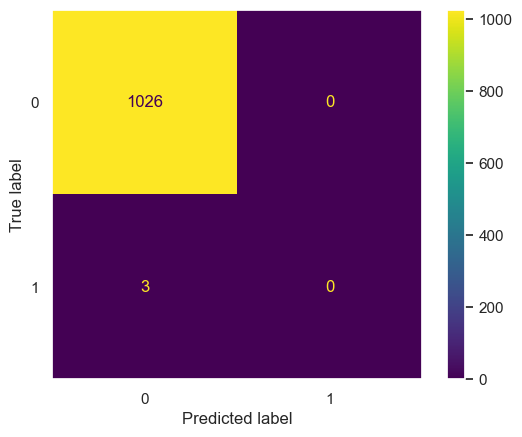

Accuracy         0.997085
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


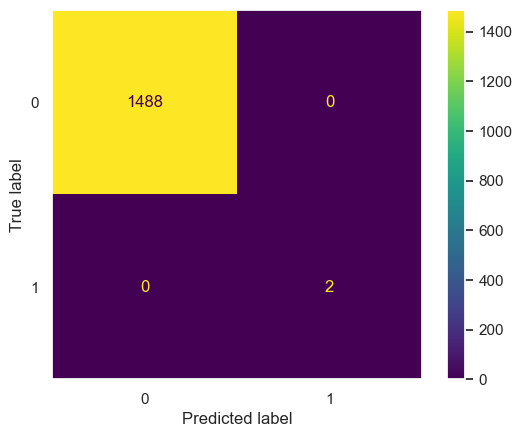

Accuracy         1.0
F1               1.0
Precision        1.0
Recall           1.0
ROC AUC Score    1.0
dtype: float64
exp type recall :  Abandoned 0.5
exp type:  Access control


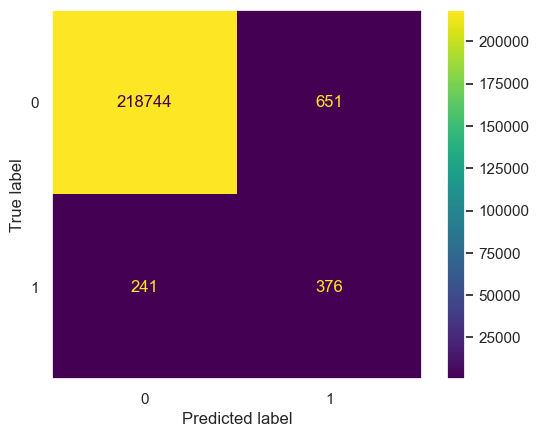

Accuracy         0.995946
F1               0.457421
Precision        0.366115
Recall           0.609400
ROC AUC Score    0.803217
dtype: float64


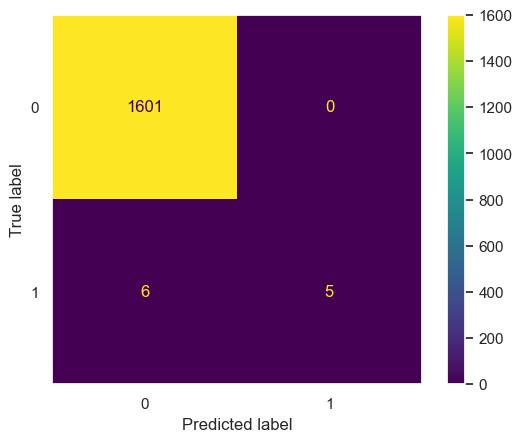

Accuracy         0.996278
F1               0.625000
Precision        1.000000
Recall           0.454545
ROC AUC Score    0.727273
dtype: float64


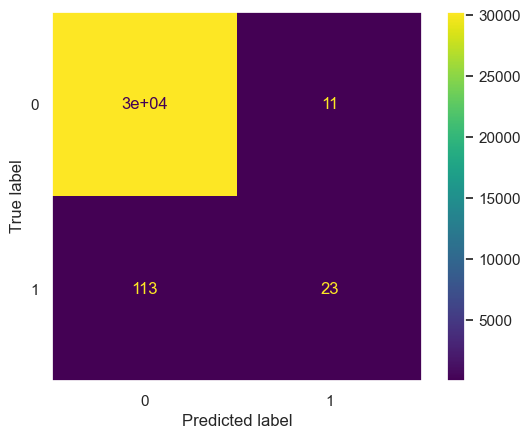

Accuracy         0.995928
F1               0.270588
Precision        0.676471
Recall           0.169118
ROC AUC Score    0.584377
dtype: float64
exp type recall :  Access control 0.4110211419177956
exp type:  Exit Scam


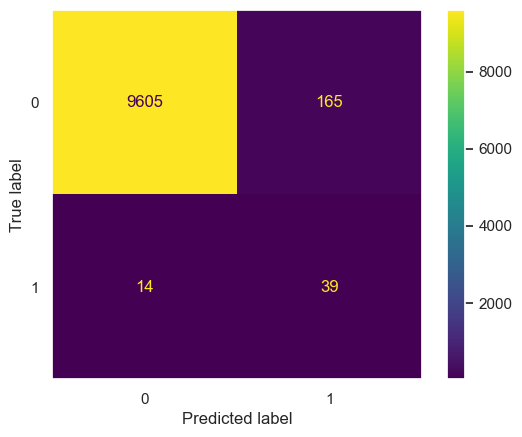

Accuracy         0.981777
F1               0.303502
Precision        0.191176
Recall           0.735849
ROC AUC Score    0.859480
dtype: float64


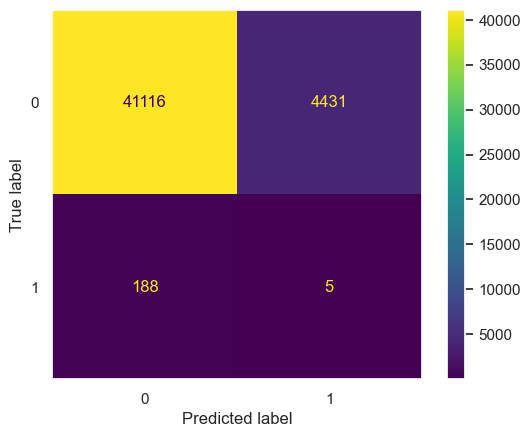

Accuracy         0.899016
F1               0.002160
Precision        0.001127
Recall           0.025907
ROC AUC Score    0.464311
dtype: float64


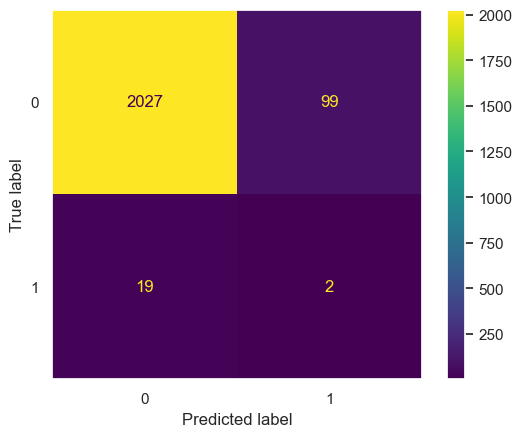

Accuracy         0.945040
F1               0.032787
Precision        0.019802
Recall           0.095238
ROC AUC Score    0.524336
dtype: float64
exp type recall :  Exit Scam 0.28566462919772134
exp type:  Exploit


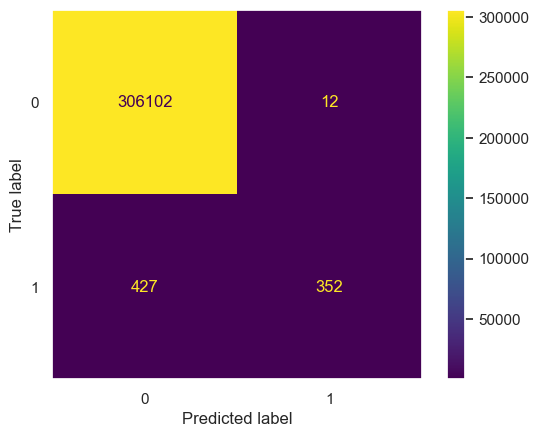

Accuracy         0.998570
F1               0.615923
Precision        0.967033
Recall           0.451861
ROC AUC Score    0.725911
dtype: float64


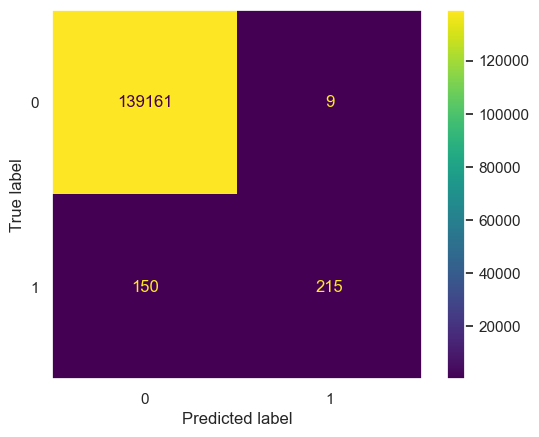

Accuracy         0.998861
F1               0.730051
Precision        0.959821
Recall           0.589041
ROC AUC Score    0.794488
dtype: float64


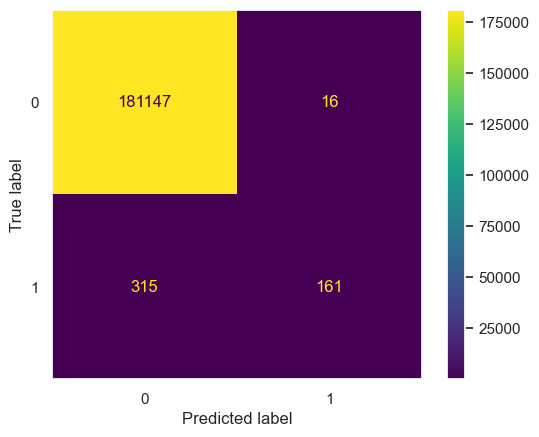

Accuracy         0.998178
F1               0.493109
Precision        0.909605
Recall           0.338235
ROC AUC Score    0.669073
dtype: float64
exp type recall :  Exploit 0.45971258357564276
exp type:  Flash Loan Attack


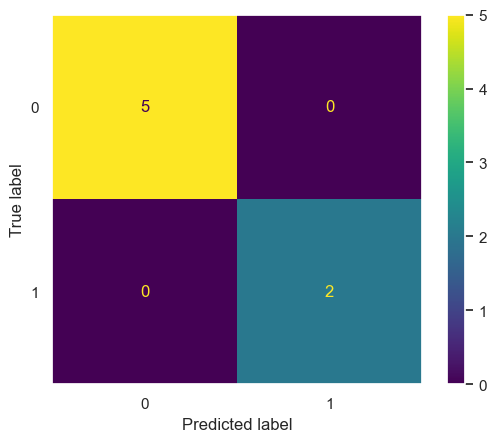

Accuracy         1.0
F1               1.0
Precision        1.0
Recall           1.0
ROC AUC Score    1.0
dtype: float64


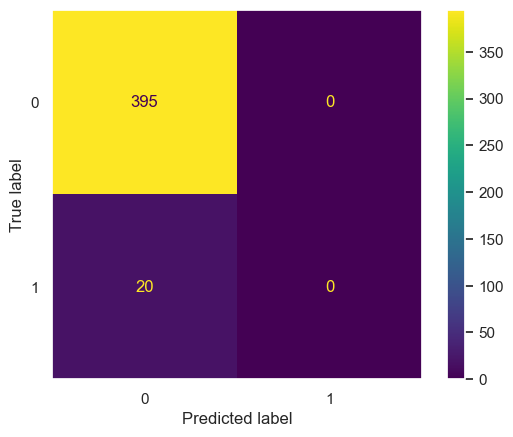

Accuracy         0.951807
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


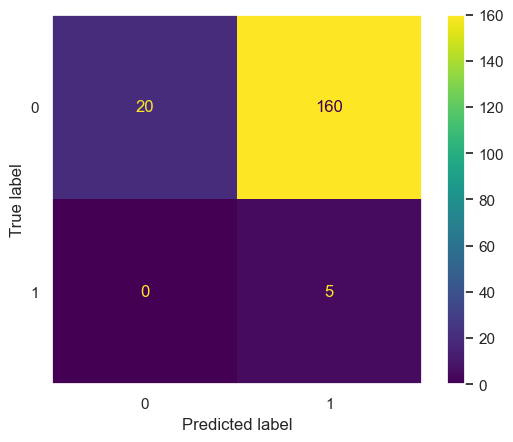

Accuracy         0.135135
F1               0.058824
Precision        0.030303
Recall           1.000000
ROC AUC Score    0.555556
dtype: float64
exp type recall :  Flash Loan Attack 0.6666666666666666
exp type:  Governance attack


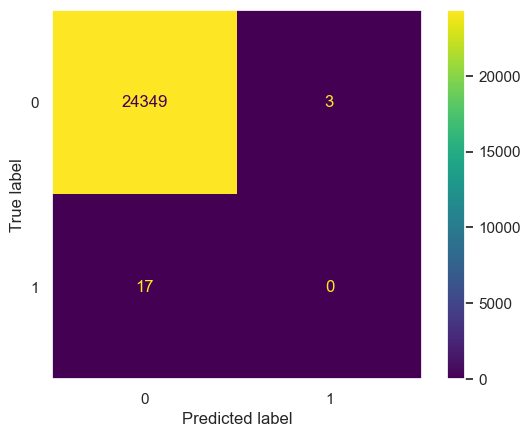

Accuracy         0.999179
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.499938
dtype: float64


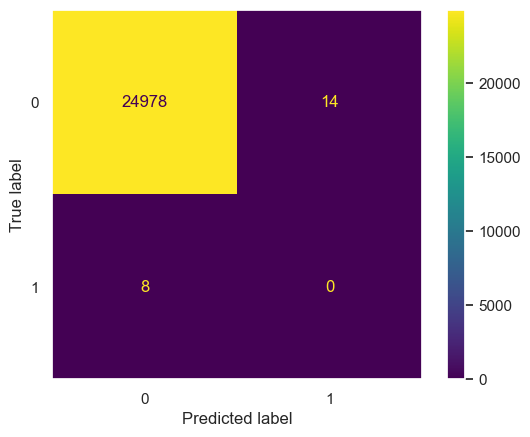

Accuracy         0.99912
F1               0.00000
Precision        0.00000
Recall           0.00000
ROC AUC Score    0.49972
dtype: float64
exp type recall :  Governance attack 0.0
exp type:  Honeypot


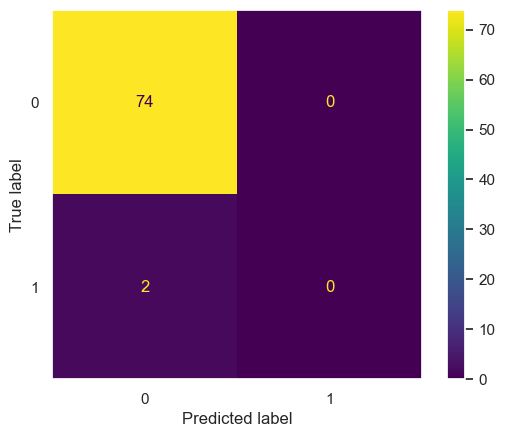

Accuracy         0.973684
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


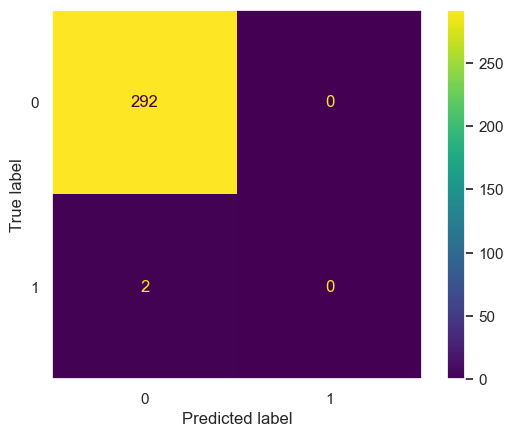

Accuracy         0.993197
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64
exp type recall :  Honeypot 0.0
exp type:  Phishing


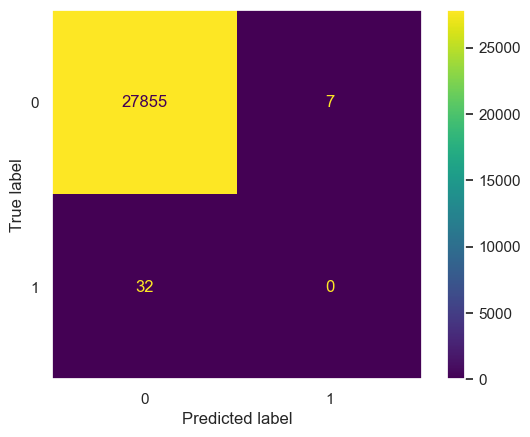

Accuracy         0.998602
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.499874
dtype: float64


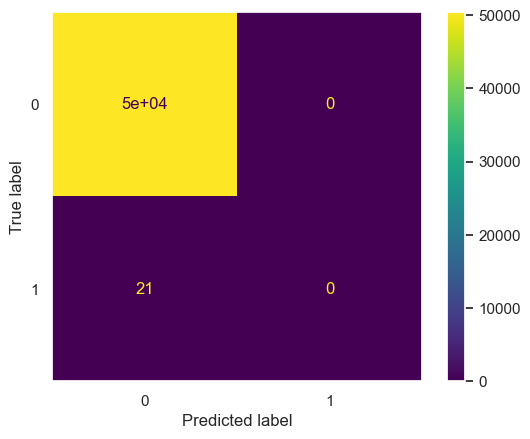

Accuracy         0.999584
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


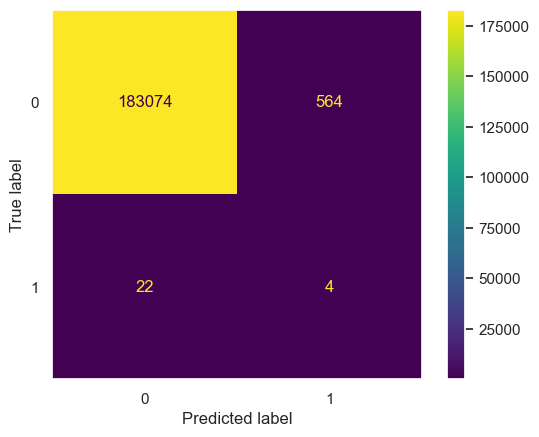

Accuracy         0.996809
F1               0.013468
Precision        0.007042
Recall           0.153846
ROC AUC Score    0.575387
dtype: float64
exp type recall :  Phishing 0.05128205128205129
exp type:  Price Manipulation


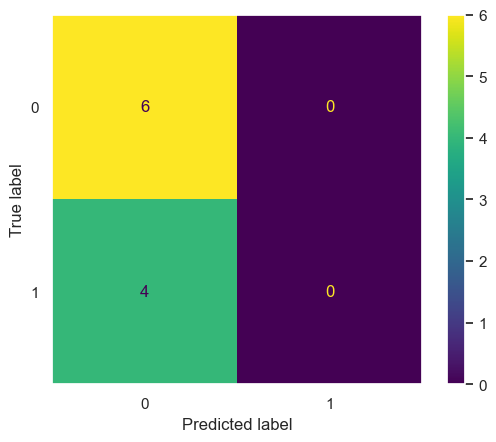

Accuracy         0.6
F1               0.0
Precision        0.0
Recall           0.0
ROC AUC Score    0.5
dtype: float64


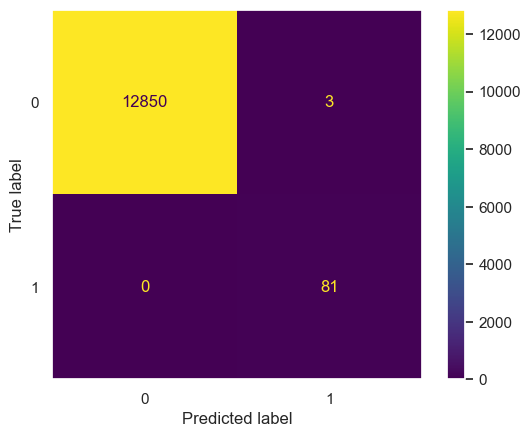

Accuracy         0.999768
F1               0.981818
Precision        0.964286
Recall           1.000000
ROC AUC Score    0.999883
dtype: float64
exp type recall :  Price Manipulation 0.5
exp type:  Private Key


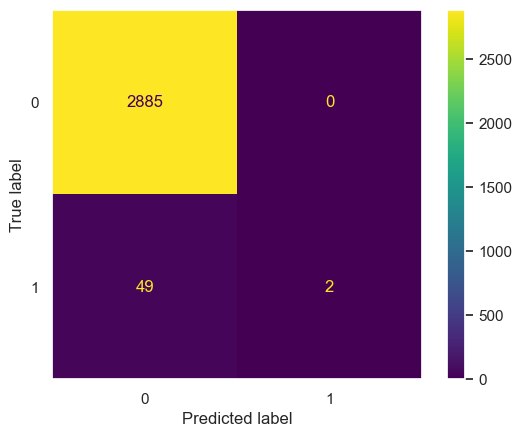

Accuracy         0.983311
F1               0.075472
Precision        1.000000
Recall           0.039216
ROC AUC Score    0.519608
dtype: float64


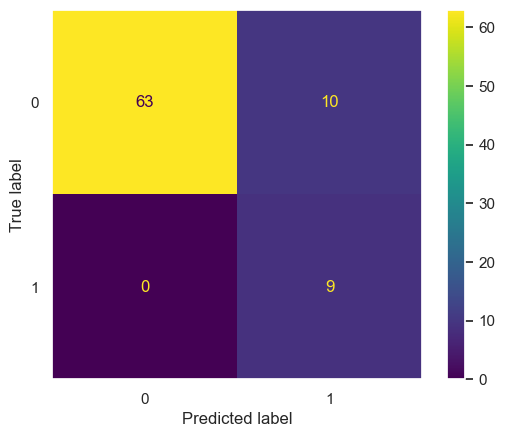

Accuracy         0.878049
F1               0.642857
Precision        0.473684
Recall           1.000000
ROC AUC Score    0.931507
dtype: float64


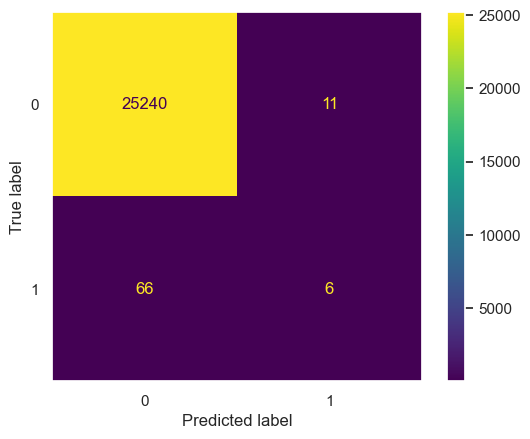

Accuracy         0.996959
F1               0.134831
Precision        0.352941
Recall           0.083333
ROC AUC Score    0.541449
dtype: float64
exp type recall :  Private Key 0.3741830065359477
exp type:  Reentrancy


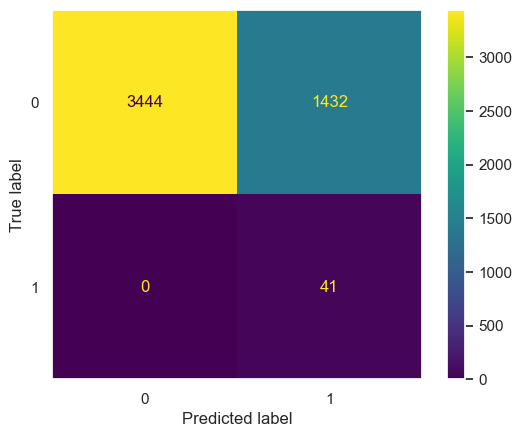

Accuracy         0.708766
F1               0.054161
Precision        0.027834
Recall           1.000000
ROC AUC Score    0.853158
dtype: float64


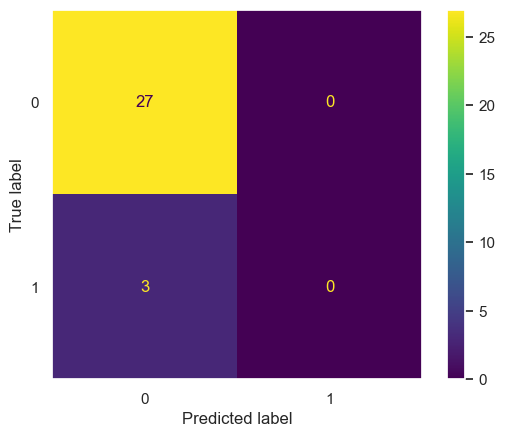

Accuracy         0.9
F1               0.0
Precision        0.0
Recall           0.0
ROC AUC Score    0.5
dtype: float64


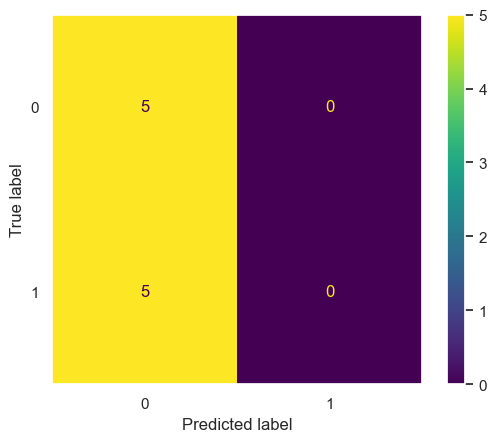

Accuracy         0.5
F1               0.0
Precision        0.0
Recall           0.0
ROC AUC Score    0.5
dtype: float64
exp type recall :  Reentrancy 0.3333333333333333
exp type:  Rugpull
exp type:  unknown


In [72]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
results = {}
for all_grp, one_grp in logo.split(mX, vY, groups = dfData_sama['Exploit Type'].to_list()):#for all_grp, one_grp in logo.split(dfData_, dfData_['Label'], groups = dfData_['Exploit Type'].to_list()):#split(X):
    print('exp type: ' , dfData_sama.iloc[one_grp]['Exploit Type'].to_list()[0])
    
    if dfData_sama.iloc[one_grp]['Exploit Type'].to_list()[0] not in ['Bank Run' , 'Rugpull', 'unknown']:
        _, mX_, _, vY_ = mX.iloc[all_grp], mX.iloc[one_grp], vY.iloc[all_grp], vY.iloc[one_grp]
        _dfData = dfData_sama.iloc[one_grp]
        hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
        
        recalls = []
        for vTrainIdx, vTestIdx in hKFoldSplt.split(mX_, vY_, groups = _dfData['Sender ID']):

            mXTrain, mXTest, vYTrain, vYTest = mX_.iloc[vTrainIdx], mX_.iloc[vTestIdx], vY_.iloc[vTrainIdx], vY_.iloc[vTestIdx]
            xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
            xgbModel.fit(mXTrain, vYTrain)
            vYPred = xgbModel.predict(mXTest)
            if vYPred.size != 0:
                DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
                print(GenClassifierSummaryResults(vYTest, vYPred))
                recalls.append(recall_score(vYTest, vYPred))
        print('exp type recall : ' , dfData_sama.iloc[one_grp]['Exploit Type'].to_list()[0] , sum(recalls)/len(recalls))
        results[dfData_sama.iloc[one_grp]['Exploit Type'].to_list()[0]] = sum(recalls)/len(recalls)
    #print('file exp: ' , dfData_.iloc[one_grp]['Exploit Type'].to_list()[0] , mX_.shape[0])  
    #dft = dfData.iloc[vTestIdx]
    #DisplayConfusionMatrix(dft['Label'], vYPred['Alert Rule'], lClasses = [0,1])
    #print('recall : ' , recall_score(dft['Label'], vYPred['Alert Rule']), '   precision: ' , precision_score(dft['Label'], vYPred['Alert Rule']))
    #results.append({dfData_.iloc[vTestIdx]['File Name'].to_list()[0] : [vYPred,recall_score(dft['Label'], vYPred['Alert Rule'])]})
    #if recall_score(vYTest, vYPred) != 1:
    #    prob_files.append(dfData_.iloc[vTestIdx]['File Name'].to_list()[0])    

In [73]:
results

{'Abandoned': 0.5,
 'Access control': 0.4110211419177956,
 'Exit Scam': 0.28566462919772134,
 'Exploit': 0.45971258357564276,
 'Flash Loan Attack': 0.6666666666666666,
 'Governance attack': 0.0,
 'Honeypot': 0.0,
 'Phishing': 0.05128205128205129,
 'Price Manipulation': 0.5,
 'Private Key': 0.3741830065359477,
 'Reentrancy': 0.3333333333333333}

In [ ]:


hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
l_sfs = ['Amount',
 'Gas Price',
 'Gas Used',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']


In [77]:
l2 = ['Amount',
 'Gas Price',
 'Gas Used']
l1 = ['AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'GAS_PRICE_STD_USR',
 'GAS_PRICE_MEDIAN_USR',
 'GAS_USED_MEAN_USR',
 'GAS_USED_STD_ASSET',
 'GAS_USED_STD_USR',
 'MIN_INDICATOR',
 'GAS_PRICE_USR_ASSET_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO',
 'GAS_PRICE_USED_RATIO_MEAN',
 'GAS_USED_LIMIT_RATIO_MEAN',
 'GAS_PRICE_QUANTILE_RATIO',
 'GAS_USED_QUANTILE_RATIO',
 'GAS_LIMIT_QUANTILE_RATIO',
 'GAS_PRICE_QUANTILE_USR',
 'GAS_USED_QUANTILE_USR']